# Tutorial 4: Dissecting local chemo-kinematic structure

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import glob
from astropy.table import Table, hstack, vstack
from astropy.coordinates import SkyCoord, Distance, Galactocentric
import astropy.units as u
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In this tutorial we will complement the Gaia data with other spectroscopic data. This demonstrates the crucial function of cross-matching large catalogues.

Gaia does not provide any metallicity or abundance information. In order to understand the chemo-kinematic structure of the Galaxy we must complement with results from other spectroscopic surveys. Here we will use GALAH as it has observations of many nearby bright stars. This uses the pre-downloaded data tables (available on USB sticks, by downloading from 

http://cdn.gea.esac.esa.int/Gaia/gdr2/gaia_source_with_rv/csv/ 

and 

https://www.ast.cam.ac.uk/~jls/data/galah_dr2.fits 

or 

https://datacentral.org.au/teamdata/GALAH/public/

). Note that as GALAH provides radial velocities we could cross-match to the entire Gaia catalogue and only use Gaia proper motions and parallaxes.

In [2]:
def read_gaia_rvs(f):
    gaia_rvs_full = pd.read_csv(f)
    fltr = (gaia_rvs_full['parallax']>5.)&(gaia_rvs_full['parallax_over_error']>3.)
    fltr &= (gaia_rvs_full['radial_velocity']>-1000.)
    fltr &= (np.abs(gaia_rvs_full['b'])>8.)
    fltr &= (gaia_rvs_full['dec']<10.)
    gaia_rvs = gaia_rvs_full[fltr].reset_index(drop=True)
    return Table.from_pandas(gaia_rvs)
gaia_rvs = vstack([read_gaia_rvs(f) for f in glob.glob('GaiaSource_*.csv')])

galah = Table.read('galah_dr2.fits')

Here we find the entries in the Gaia RVS table that correspond to entries in the GALAH DR2 table. This will find the entry that is closest in $(\Delta\alpha\cos\delta,\Delta\delta)$.

In [3]:
gaia_rvs_skycoord = SkyCoord(ra=gaia_rvs['ra']*u.deg, 
                             dec=gaia_rvs['dec']*u.deg)  
galah_skycoord  = SkyCoord(ra=galah['raj2000']*u.degree, 
                           dec=galah['dej2000']*u.degree)  
idx, dist_onsky, d3d = galah_skycoord.match_to_catalog_sky(
                    gaia_rvs_skycoord)

We join the tables and then only keep entries where the cross-match distance was less than 3 arcsec.

No. of XMatches= 6698


Text(0.5, 0, 'Cross-match distance / arcsec')

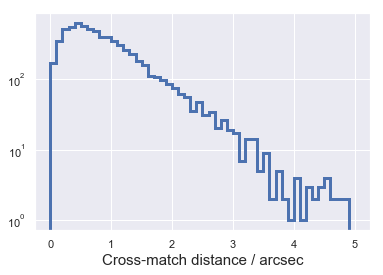

In [4]:
gaia_xm = hstack([galah,gaia_rvs[idx]])[dist_onsky<3.*u.arcsec]
print('No. of XMatches=',len(gaia_xm))
plt.hist(dist_onsky.arcsec,range=[0.,5.],histtype='step',lw=3,bins=50);
plt.semilogy()
plt.xlabel('Cross-match distance / arcsec')

We can compare the radial velocities from Gaia and GALAH. Pretty good.

Text(0.5, 0, 'Vel. diff / km/s')

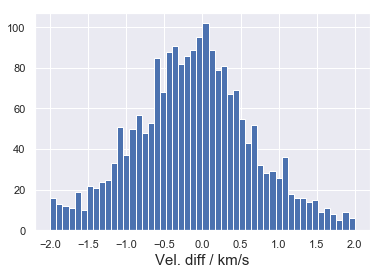

In [5]:
plt.hist(gaia_xm['rv_obst']-gaia_xm['radial_velocity'],range=[-2.,2.],bins=50);
plt.xlabel('Vel. diff / km/s')

The cross-match metallicity distribution is similar to all of GALAH.

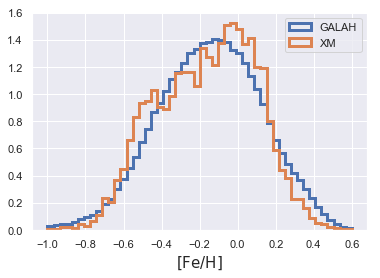

In [6]:
plt.hist(galah['fe_h'],range=[-1.,0.6],normed=True,
         histtype='step',lw=3,bins=50,label='GALAH')
plt.hist(gaia_xm['fe_h'],range=[-1.,0.6],normed=True,
         histtype='step',lw=3,bins=50,label='XM')
plt.xlabel(r'$[\mathrm{Fe}/\mathrm{H}]$')
plt.legend()

## Velocity distributions split by metallicity

In [7]:
# allow_negative means the distance=nan if parallax<0
s = SkyCoord(ra=gaia_xm['ra']*u.deg,dec=gaia_xm['dec']*u.deg,
             distance=Distance(
                 parallax=gaia_xm['parallax'].data.data*u.mas, 
                 allow_negative=True),
             pm_ra_cosdec=gaia_xm['pmra']*u.mas/u.yr,
             pm_dec=gaia_xm['pmdec']*u.mas/u.yr,
             radial_velocity=gaia_xm['radial_velocity']*u.km/u.s)
galcen = s.transform_to(Galactocentric)

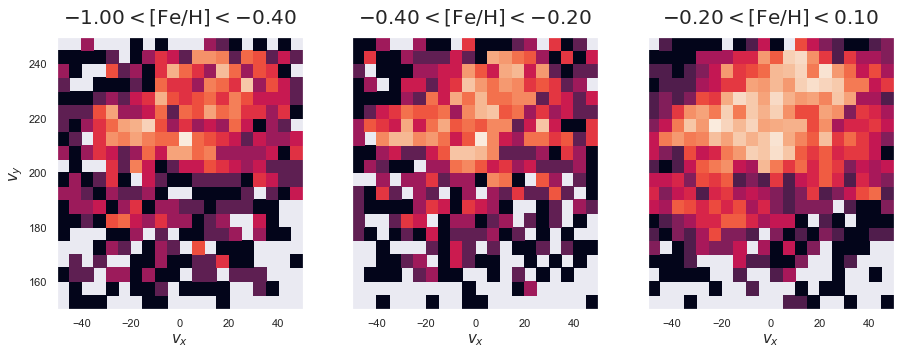

In [8]:
f,a=plt.subplots(1,3,figsize=[15.,5.],sharey=True)
feh_range = [-1.,-0.4,-0.2,0.1]
from matplotlib.colors import LogNorm
for f in range(len(feh_range)-1):
    plt.sca(a[f])
    fltr = (gaia_xm['fe_h']>feh_range[f])&(gaia_xm['fe_h']<feh_range[f+1])
    plt.hist2d(galcen.v_x.value[fltr],galcen.v_y.value[fltr], bins=20,
              range=[[-50,50],[150.,250.]],norm=LogNorm(),normed=True)
    plt.annotate(r'$%0.2f<[\mathrm{Fe}/\mathrm{H}]<%0.2f$'\
                 %(feh_range[f],feh_range[f+1]),
                xy=(0.5,1.05),xycoords='axes fraction',
                 ha='center',fontsize=20)
    plt.xlabel(r'$v_x$')
plt.sca(a[0])
plt.ylabel(r'$v_y$');

The Hercules is definitely more visible in the metal-rich bin.

We have demonstrated how to cross-match catalogues. This is necessary if we want to use Gaia with any chemical abundance information. We have used this to inspect the local velocity structure separated by metallicity. 

Things to do next:

1. Subdivide based on other abundances
2. Inspect action, angle, frequency diagrams split by abundance
3. Investigate vertical distributions (Gaia spiral)

See Bland-Hawthorn et al. (2018)